# Expanding/shrinking box

Objective is to reduce the iteration space at leach time level.

Define a dynamic domain which is defined as the intersection between:
* the minimum rectangular subdomain that contains information propogating from one or more sources, 
* the minimum rectangular subdomain from which information can reach receivers before the end time, and
* the original domain.


In [1]:
# Helper functions to illustrate the algorithm. 

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation, PillowWriter

mpl.rc('font', size=16)
mpl.rc('figure', figsize=(8, 6))
        
def update(time, bbox, line):
    x = [bbox[time, 0], bbox[time, 1], bbox[time, 1], bbox[time, 0], bbox[time, 0]]
    y = [bbox[time, 2], bbox[time, 2], bbox[time, 3], bbox[time, 3], bbox[time, 2]]
    line.set_data(x, y)
    return line,

# Duplicated from examples to add support for overlaying the expanding box. 
def plot_velocity(model, source=None, receiver=None, colorbar=True, cmap="jet", bbox=None):
    domain_size = np.array(model.domain_size)
    extent = [model.origin[0], model.origin[0] + domain_size[0],
              model.origin[1] + domain_size[1], model.origin[1]]
    
    slices = tuple(slice(model.nbl, -model.nbl) for _ in range(2))
    if getattr(model, 'vp', None) is not None:
        field = model.vp.data[slices]
    else:
        field = model.lam.data[slices]
    plot = plt.imshow(np.transpose(field), animated=True, cmap=cmap,
                      vmin=np.min(field), vmax=np.max(field),
                      extent=extent)
    plt.xlabel('X position (meters)')
    plt.ylabel('Depth (meters)')

    # Plot source points, if provided
    if receiver is not None:
        plt.scatter(receiver[:, 0], receiver[:, 1],
                    s=25, c='white', marker='o')

    # Plot receiver points, if provided
    if source is not None:
        plt.scatter(source[:, 0], source[:, 1],
                    s=25, c='white', marker='x')
    # Ensure axis limits
    plt.xlim(model.origin[0], model.origin[0] + domain_size[0])
    plt.ylim(model.origin[1] + domain_size[1], model.origin[1])

    ax = plt.gca()
    fig = plt.gcf()


    if bbox is not None:
        x = [bbox[0, 0], bbox[0, 1], bbox[0, 1], bbox[0, 0], bbox[0, 0]]
        y = [bbox[0, 2], bbox[0, 2], bbox[0, 3], bbox[0, 3], bbox[0, 2]]

        line, = plt.plot(x, y, c='white')

        ani = animation.FuncAnimation(fig, update, bbox.shape[0], fargs=[bbox, line],
                                      interval=25, blit=True)
        ani.save("movie.gif", writer=PillowWriter(fps=24))

    # Create aligned colorbar on the right
    if colorbar:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        cbar = plt.colorbar(plot, cax=cax)
        cbar.set_label('Velocity (km/s)')

    plt.show()

def coord2index(grid, coord):
    return (int((coord[0] - grid.origin[0])/grid.spacing[0]),
            int((coord[1] - grid.origin[1])/grid.spacing[1]))

Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s


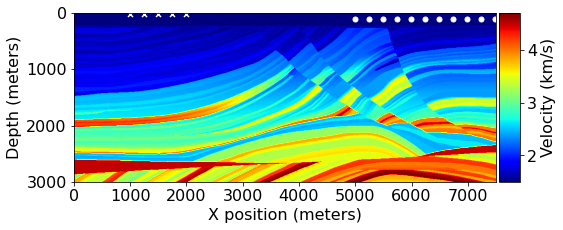

In [2]:
# POC setup

import os
import numpy as np
from examples.seismic import preset_models
from math import ceil, sqrt, atan, sin

model = preset_models.demo_model(preset='marmousi-isotropic', data_path="../data")

nsources = 5
src_coordinates = np.empty((nsources, 2))

src_coordinates[:, 0] = np.linspace(1000, 2000, num=nsources)
src_coordinates[:, 1] = 10.  

nreceivers = 11
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(5000,
                                    model.domain_size[0] - model.spacing[0], num=nreceivers)
rec_coordinates[:, 1] = 100.

plot_velocity(model, source=src_coordinates, receiver=rec_coordinates)

# Estimate time taken to travel from one corner to the bottom of the middle of the bottom,
# and up the other side.
time_steps = 0
distance_traveled = 0
diagonal = sqrt((model.grid.extent[0]/2)**2 + model.grid.extent[1]**2)
sin_angle = sin(atan(model.grid.extent[1]/(model.grid.extent[0]/2)))

while distance_traveled<diagonal:
    depth = sin_angle*distance_traveled
    idepth = int(depth/model.spacing[1])
    ds = model.critical_dt*model.vp.data[:, idepth].max()
    
    time_steps += 2
    distance_traveled += ds


## Source bounding box

Define a list of sources as

$S = {s_0, ..., s_i, ..., s_n}$

where the $i^{th}$ source coordinate is $(sx_i, sy_i, sz_i)$.

Define the initial bounding box around the sources as

$$
\begin{aligned}
s^{bbox} &= \left(\min_i\left( sx_i \right) - so*dx, \max_i\left( sx_i \right) + so*dx,
                  \min_i\left( sy_i \right) - so*dx, \max_i\left( sy_i \right) + so*dx,
                  \min_i\left( sz_i \right) - so*dx, \max_i\left( sz_i \right) + so*dx\right) \\
         &= \left(s^{bbox}_0, s^{bbox}_1, s^{bbox}_2, s^{bbox}_3, s^{bbox}_4, s^{bbox}_5\right).
\end{aligned}
$$
where $so$ is both the space order of the discritisation, which is also the maximum space order of the source.

At the $j^{th}$ time step the maximum distance information has traveled is defined as 
$$d^s_{max:j} = j*dt*c_{max},$$

where $c_{max}$ is the maximum speed of sound in the domain. Therefore, the source bounding box at time step $j$ is defined as:
$$
s^{bbox:j} = \left(s^{bbox}_0 - d^s_{max:j},
                   s^{bbox}_1 + d^s_{max:j},
                   s^{bbox}_2 - d^s_{max:j},
                   s^{bbox}_3 + d^s_{max:j},
                   s^{bbox}_4 - d^s_{max:j},
                   s^{bbox}_5 + d^s_{max:j}\right).
$$

## Receiver bounding box

Define a list of receivers as

$R = {r_0, ..., r_i, ..., r_n}$

where the $i^{th}$ receiver coordinate is $(rx_i, ry_i, rz_i)$.

At the $j^{th}$ time step the maximum distance from the receiver from which information can still back to the receiver is defined as $d^r_{max:j} = (j^{max} - j)*dt*c_{max} + so*dx$. 


Define the initial bounding box around the receivers as

$$
\begin{aligned}
r^{bbox} &= \left(r^{bbox}_0, r^{bbox}_1, r^{bbox}_2, r^{bbox}_3, r^{bbox}_4, r^{bbox}_r\right)\\
         &= \left(\min_i\left( rx_i \right) - d^r_{max:j}, \max_i\left( rx_i \right) + d^r_{max:j},
                  \min_i\left( ry_i \right) - d^r_{max:j}, \max_i\left( ry_i \right) + d^r_{max:j},
                  \min_i\left( rz_i \right) - d^r_{max:j}, \max_i\left( rz_i \right) + d^r_{max:j} \right).
\end{aligned}.
$$

Therefore, the receiver bounding box at time step $j$ is defined as:
$$
r^{bbox:j} = \left(r^{bbox}_0 + j*dt*c_{max},
                   r^{bbox}_1 - j*dt*c_{max},
                   r^{bbox}_2 + j*dt*c_{max},
                   r^{bbox}_3 - j*dt*c_{max},
                   r^{bbox}_4 + j*dt*c_{max},
                   r^{bbox}_5 - j*dt*c_{max}\right).
$$

## Active domain 
The active domain at time step $j$ is defined as the intersection between the original domain $= (x_{min}, x_{max}, y_{min}, y_{max}, z_{min}, z_{max})$, $r^{bbox:j}$ and $s^{bbox:j}$,

$$ = \left(
\max\left(x_{min}, s^{bbox:j}[0], r^{bbox:j}[0]\right),
\min\left(x_{max}, s^{bbox:j}[1], r^{bbox:j}[1]\right),
\max\left(y_{min}, s^{bbox:j}[2], r^{bbox:j}[2]\right),
\min\left(y_{max}, s^{bbox:j}[3], r^{bbox:j}[3]\right),
\max\left(z_{min}, s^{bbox:j}[4], r^{bbox:j}[4]\right),
\min\left(z_{max}, s^{bbox:j}[5], r^{bbox:j}[5]\right),
\right), 
$$

## Optimisation 1

Rather than using the maximum velocity in the whole domain, we use the maximum velocity on the facet of the box.

In [3]:
from numba import jit

extent = np.array([model.origin[0],
                   model.origin[0] + model.domain_size[0],
                   model.origin[1],
                   model.origin[1] + model.domain_size[1]], dtype=np.float32)
          
@jit(nopython=True)
def create_bbox(origin, dt, shape, spacing, time_steps,
                src_coordinates, rec_coordinates,
                so, extent, vp):
    sbbox = np.zeros((time_steps, 4))

    # Bounding box around source coordinates + radius of stencil operator. 
    sbbox[0, 0] = max(extent[0], np.min(src_coordinates[:, 0]) - so*spacing[0])
    sbbox[0, 1] = min(extent[1], np.max(src_coordinates[:, 0]) + so*spacing[0])
    sbbox[0, 2] = max(extent[2], np.min(src_coordinates[:, 1]) - so*spacing[1])
    sbbox[0, 3] = min(extent[3], np.max(src_coordinates[:, 1]) + so*spacing[1])
        
    for i in range(1, time_steps):
        ibox = [int((sbbox[i-1, 0] - origin[0])/spacing[0]),
                int((sbbox[i-1, 1] - origin[0])/spacing[0]),
                int((sbbox[i-1, 2] - origin[1])/spacing[1]),
                int((sbbox[i-1, 3] - origin[1])/spacing[1])]
        
        cmax = [vp[ibox[0], ibox[2]:ibox[3]].max(),
                vp[ibox[1], ibox[2]:ibox[3]].max(),
                vp[ibox[0]:ibox[1], ibox[2]].max(),
                vp[ibox[0]:ibox[1], ibox[3]].max()]
        
        sbbox[i, 0] = max(extent[0], sbbox[i-1, 0] - dt*cmax[0])
        sbbox[i, 1] = min(extent[1], sbbox[i-1, 1] + dt*cmax[1])
        sbbox[i, 2] = max(extent[2], sbbox[i-1, 2] - dt*cmax[2])
        sbbox[i, 3] = min(extent[3], sbbox[i-1, 3] + dt*cmax[3])

    rbbox = np.empty((time_steps, 4))

    rbbox[-1, 0] = max(np.min(rec_coordinates[:, 0]) - so*spacing[0], extent[0])
    rbbox[-1, 1] = min(np.max(rec_coordinates[:, 0]) + so*spacing[0], extent[1])
    rbbox[-1, 2] = max(np.min(rec_coordinates[:, 1]) - so*spacing[1], extent[2])
    rbbox[-1, 3] = min(np.max(rec_coordinates[:, 1]) + so*spacing[1], extent[3])
    for i in range(1, time_steps):
        ibox = [int((rbbox[-i, 0] - origin[0])/spacing[0]),
                int((rbbox[-i, 1] - origin[0])/spacing[0]),
                int((rbbox[-i, 2] - origin[1])/spacing[1]),
                int((rbbox[-i, 3] - origin[1])/spacing[1])]
        
        cmax = [vp[ibox[0], ibox[2]:ibox[3]].max(),
                vp[ibox[1], ibox[2]:ibox[3]].max(),
                vp[ibox[0]:ibox[1], ibox[2]].max(),
                vp[ibox[0]:ibox[1], ibox[3]].max()]
        
        rbbox[-(i+1), 0] = rbbox[-i, 0] - dt*cmax[0]            
        rbbox[-(i+1), 1] = rbbox[-i, 1] + dt*cmax[1]
        rbbox[-(i+1), 2] = rbbox[-i, 2] - dt*cmax[2]
        rbbox[-(i+1), 3] = rbbox[-i, 3] + dt*cmax[3]

        if rbbox[-(i+1), 0] < extent[0]:
            rbbox[-(i+1), 0] = extent[0]
        elif rbbox[-(i+1), 0] > extent[1]:
            rbbox[-(i+1), 0] = extent[1]
            
        if rbbox[-(i+1), 1] < extent[0]:
            rbbox[-(i+1), 1] = extent[0]
        elif rbbox[-(i+1), 1] > extent[1]:
            rbbox[-(i+1), 1] = extent[1]
            
        if rbbox[-(i+1), 2] < extent[2]:
            rbbox[-(i+1), 2] = extent[2]
        elif rbbox[-(i+1), 2] > extent[3]:
            rbbox[-(i+1), 2] = extent[3]
            
        if rbbox[-(i+1), 3] < extent[2]:
            rbbox[-(i+1), 3] = extent[2]
        elif rbbox[-(i+1), 3] > extent[3]:
            rbbox[-(i+1), 3] = extent[3]
                    
    bbox = np.zeros((time_steps, 4))
    for i in range(time_steps):
        bbox[i, 0] = max([sbbox[i, 0], rbbox[i, 0], extent[0]])
        bbox[i, 1] = min([sbbox[i, 1], rbbox[i, 1], extent[1]])
        bbox[i, 2] = max([sbbox[i, 2], rbbox[i, 2], extent[2]])
        bbox[i, 3] = min([sbbox[i, 3], rbbox[i, 3], extent[3]])
        
    return bbox, rbbox, sbbox

In [4]:
bbox, rbbox, sbbox = create_bbox(model.origin, model.critical_dt, model.shape, model.spacing, time_steps,
                                 src_coordinates, rec_coordinates, 16,
                                 extent, model.vp.data[:])

print(type(time_steps))

<class 'int'>


In [5]:
new_space = sum((bbox[:, 1]-bbox[:, 0])*(bbox[:, 3]-bbox[:, 2]))
old_space = (time_steps*(extent[1]-extent[0])*(extent[3]-extent[2]))

print("optimised iteration space/original iteration space = %.2f", new_space/old_space)

optimised iteration space/original iteration space = %.2f 0.48948911433107095


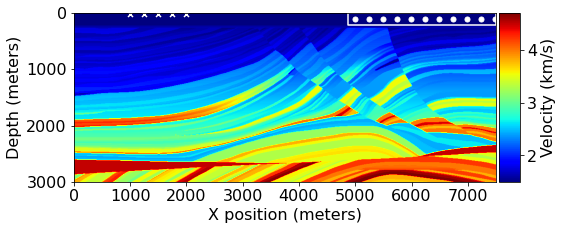

In [6]:
plot_velocity(model, source=src_coordinates, receiver=rec_coordinates, bbox=bbox[::20, :])


Text(0, 0.5, 'domain area')

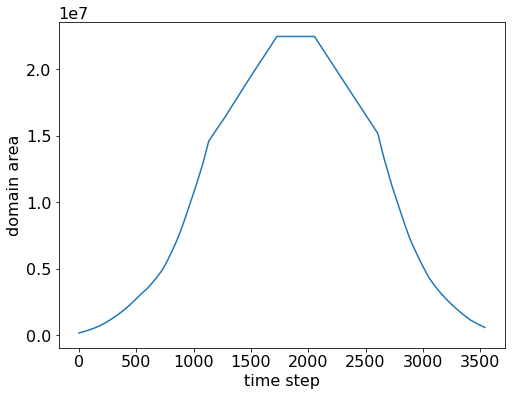

In [7]:
area = (bbox[:, 1]-bbox[:, 0])*(bbox[:, 3]-bbox[:, 2])
plt.plot(area)
plt.xlabel("time step")
plt.ylabel("domain area")

Text(0, 0.5, 'domain area')

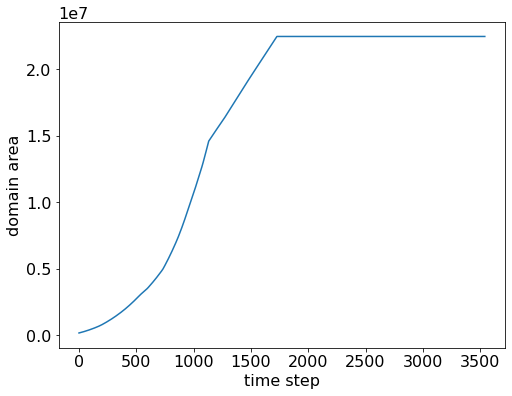

In [8]:
area = (sbbox[:, 1]-sbbox[:, 0])*(sbbox[:, 3]-sbbox[:, 2])
plt.plot(area)
plt.xlabel("time step")
plt.ylabel("domain area")

Text(0, 0.5, 'domain area')

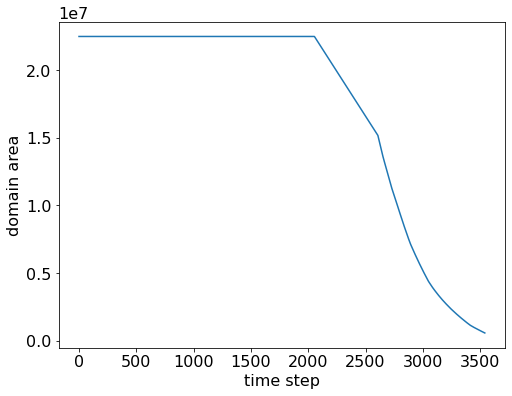

In [9]:
area = (rbbox[:, 1]-rbbox[:, 0])*(rbbox[:, 3]-rbbox[:, 2])
plt.plot(area)
plt.xlabel("time step")
plt.ylabel("domain area")